In [1]:
#### Parsing phased VCF file containing two sample for comparison


vcf_file_address =  "/Volumes/uni/myjupyter/jupyter_phaseme/comparison/ont_patmat/improved/22_ont_imp_patmat.vcf"
#"/Volumes/uni/myjupyter/jupyter_phaseme/comparison/ont_patmat/22_ont_patmat.vcf"
#"/Volumes/uni/myjupyter/jupyter_phaseme/comparison/10x_patmat/22_10x_patmat.vcf"
# "/Volumes/uni/myjupyter/jupyter_phaseme/comparison/10x_true/22_10x_true.vcf"

#  '/Volumes/uni/myjupyter/jupyter_phaseme/ont/22_ont_improved_98.vcf'
#'/Volumes/uni/myjupyter/jupyter_phaseme/comparison/ont_true/22_ont_true.vcf'
#"/Volumes/uni/myjupyter/jupyter_phaseme/comparison/10x_true/22_10x_true.vcf"

#

 
vcf_file = open(vcf_file_address,'r'); 

hap_blocks_sample1_dic={} # key: id of phase block (i.e. phase st), value= {genomic_position:allele_1}
hap_blocks_sample2_dic={} 

header_lines_list=[]
for line in vcf_file:
    line_strip=line.strip() 
    if line_strip.startswith('#'):
        header_lines_list.append(line_strip)
        sample_names=line_strip.split('\t')[9:11]# last line of header contains sample name
    else:
        #var_indx+=1
          
        # '22\t51244182\t.\tG\tA\t.\t.\t.\tGT:GQ:DP:AF:GL:PS\t
        #  0|1:127:.:.:-58.12751217387621,-8.336610948353968e-14,-12.716893473415803:50415657'
        line_parts=line_strip.split('\t') 
        
        gt_flags, sample1, sample2 = line_parts[8:11]
        if "|" in sample1 and "|" in sample2: # both sample are phased for this variant

            var_pos=int(line_parts[1])
            
            sample1_split=sample1.split(":")
            sample2_split=sample2.split(":")
            
            gt_flags_split=gt_flags.split(":")
            
            block_id1 = sample1_split[gt_flags.split(":").index("PS")] #int(
            block_id2 = sample2_split[gt_flags.split(":").index("PS")] #int(
            
            allele_sample1=sample1_split[gt_flags.split(":").index("GT")]
            allele_sample2=sample2_split[gt_flags.split(":").index("GT")]

            if (allele_sample1 == '0|1' or allele_sample1 == '1|0') and (allele_sample2 == '0|1' or allele_sample2 == '1|0'):
                if block_id1 in hap_blocks_sample1_dic:
                    hap_blocks_sample1_dic[block_id1][var_pos]=allele_sample1 # append new variants to the existing phase block
                else:
                    hap_blocks_sample1_dic[block_id1]={var_pos:allele_sample1} # creat new phase block

                if block_id2 in hap_blocks_sample2_dic:
                    hap_blocks_sample2_dic[block_id2][var_pos]=allele_sample2 # append new variants to the existing phase block
                else:
                    hap_blocks_sample2_dic[block_id2]={var_pos:allele_sample2} # creat new phase block


#print(gt_flags_split,block_id1,block_id2,allele_sample1,allele_sample2)



# hap_blocks_sample1_dic ont
# hap_blocks_sample2_dic 10x (grand truth)


In [2]:
print('Number of blocks in sample:',len(hap_blocks_sample1_dic))
#print('Number of blocks in grand truth:',len(hap_blocks_sample2_dic))

Number of blocks in sample: 15


In [3]:
for block_id in  hap_blocks_sample1_dic.keys():
    print(block_id, len(hap_blocks_sample1_dic[block_id]))


16960113 898
18873806 1141
20610824 328
21732452 959
24916182 1874
27896908 9
27904170 4486
37400787 174
37627246 476
39054450 2851
44814180 918
45706994 391
46247222 938
47886663 1907
50415657 376


In [4]:

parental_origin_blocks = {}


for block_id_sample1, hap_block_sample1 in hap_blocks_sample1_dic.items():
    
    parental_origin_block ={}
    

    for block_id_sample2, hap_block_sample2 in hap_blocks_sample2_dic.items():
        parental_origin_block_shared = []

        var_pos_list = sorted(list(hap_block_sample1.keys()))
        for var_i, var_pos in enumerate(var_pos_list):

            allele_sample1 = hap_block_sample1[var_pos]
            if var_pos in hap_block_sample2.keys():

                allele_sample2 = hap_block_sample2[var_pos]
                allele_sample2_revert = str(1-int(allele_sample2[0]))+'|'+str(1-int(allele_sample2[2]))


                if allele_sample1 == allele_sample2:
                    parental_origin = 1 #zero_one  # considering the sample1 block constant, for each grand truth, we need to change this value

                if allele_sample1 == allele_sample2_revert :
                    parental_origin = 0 #1- zero_one


                parental_origin_block_shared.append(parental_origin)
        if len(parental_origin_block_shared)>= 2:
            parental_origin_block[block_id_sample2]=parental_origin_block_shared

    if len(parental_origin_block)> 0:
        parental_origin_blocks[block_id_sample1] = parental_origin_block
    
    
    

In [5]:
for block_id in  parental_origin_blocks.keys():
    print(block_id, len(parental_origin_blocks[block_id])) # numebr of shared block for each block in sample

    

16960113 1
18873806 1
20610824 1
21732452 1
24916182 1
27896908 1
27904170 1
37400787 1
37627246 1
39054450 1
44814180 1
45706994 1
46247222 1
47886663 1
50415657 1


In [6]:

list_all_consecutive= []
list_all_blocks ={}
for block_id_sample1, parental_origin_block in parental_origin_blocks.items(): 
    
    list_all_block ={}        
    for block_id_sample2, parental_origin_block_shared in parental_origin_block.items(): 
        
        new_list=[0]
        
        for i in range(len(parental_origin_block_shared)):
            
            if i >=1:
                if parental_origin_block_shared[i] != parental_origin_block_shared[i-1]:
                    new_list.append(i)  #  consists of the starting position of a var that its parental origin (comapred to true) is different than previous ar
        new_list.append(len(parental_origin_block_shared))
        list_all_consecutive.append(new_list)
        list_all_block[block_id_sample2]=new_list
    list_all_blocks[block_id_sample1]=list_all_block


In [7]:

# list_length_blocks ={}
# for block_id_sample1, list_all_block in list_all_blocks.items(): 

#     list_length_block = {}

#     for block_id_sample2, list1 in list_all_block.items(): 

#         list_length = []
#         for i in range(1,len(list1)):
#             length1= list1[i]-list1[i-1]
#             list_length.append(length1)            
            
#         list_length_block[block_id_sample2]=list_length
#     list_length_blocks[block_id_sample1]=list_length_block
  

In [8]:
print(hap_blocks_sample1_dic.keys())
print(hap_blocks_sample2_dic.keys())

dict_keys(['16960113', '18873806', '20610824', '21732452', '24916182', '27896908', '27904170', '37400787', '37627246', '39054450', '44814180', '45706994', '46247222', '47886663', '50415657'])
dict_keys(['PATMAT'])


In [9]:
for block_id in  hap_blocks_sample2_dic.keys():
    print(block_id, len(hap_blocks_sample2_dic[block_id]))

PATMAT 17726


In [10]:


list_length_minor = [] # flipped or same 

for list1 in list_all_consecutive: #  list1  consists of the starting position of a var that its parental origin (comapred to true) is different than previous ar

    list_length = []
    for i in range(1,len(list1)):
        length1= list1[i]-list1[i-1]
        list_length.append(length1)            
        #list_length_all_consecutive.append(length1)
        #if i!=1: list_length_all_consecutive_except_first.append(length1)
    

    odd_sum = sum(list_length[0::2])
    even_sum = sum(list_length[1::2])
    min_sum= min([odd_sum, even_sum] )
    val = [odd_sum, even_sum].index(min_sum)
    length_minor=list_length[val::2]
    
    list_length_minor +=length_minor

        

         
        
        
        
    

In [11]:
len(list_length_minor)

55

In [12]:
import numpy as np

list_length_minor= np.array(list_length_minor)

lower_than_21=[length1<21 for length1 in list_length_minor]
greater_than_20=[length1>20 for length1 in list_length_minor]

print(sum(lower_than_21),sum(greater_than_20))


43 12


In [13]:
list_length_minor[greater_than_20]

array([170,  80, 137,  76, 130, 202,  76, 492,  24,  68, 624,  24])

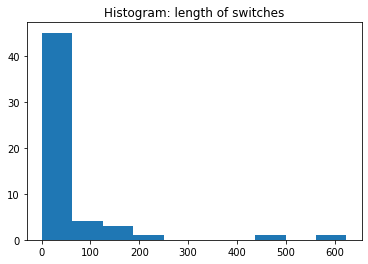

In [15]:
import matplotlib.pyplot as plt

plt.hist(list_length_minor)  # arguments are passed to np.histogram
plt.title('Histogram: length of switches')
plt.show()
# number of consecutive SNVs that are in miniorty in each shared block compared to grand truth